Fitting 5 folds for each of 20 candidates, totalling 100 fits
MAE: 4.56
RMSE: 6.71
R²: 0.9199


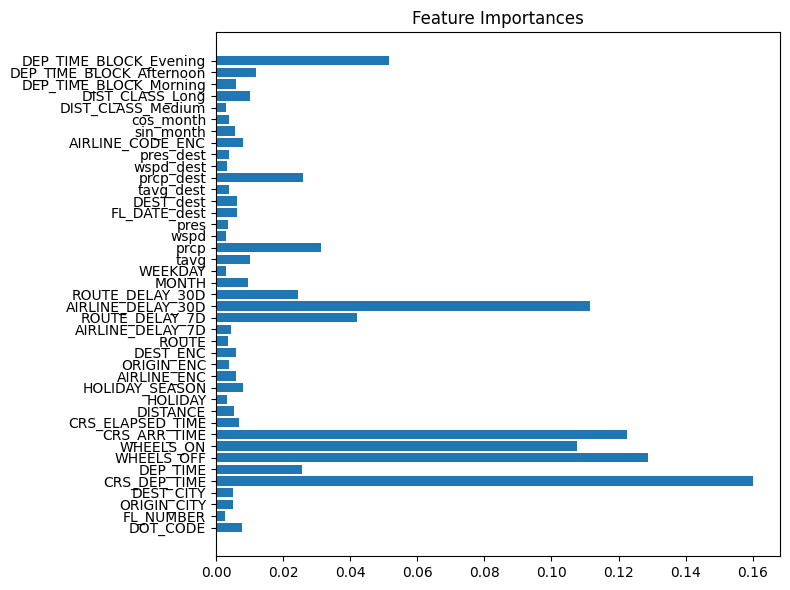

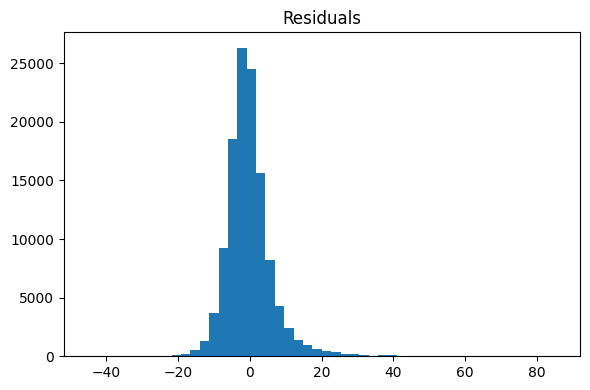

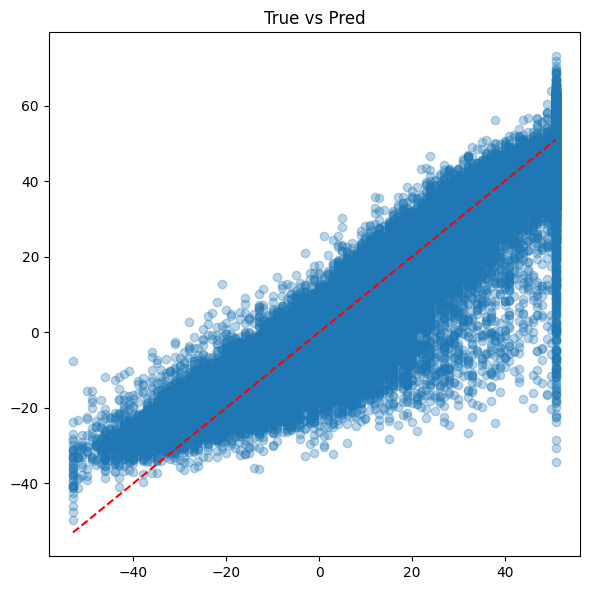

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1) Öncelikle birleşik veri setini yükleyin (hava durumu dahil)
df = pd.read_csv('merged_dataset.csv', parse_dates=['FL_DATE'])

# 2) Temel temizleme: iptal ve yönlendirilmiş uçuşları çıkar, ARR_DELAY boşsa düşür
if 'CANCELLED' in df.columns:
    df = df[df['CANCELLED'] != 1]
if 'DIVERTED' in df.columns:
    df = df[df['DIVERTED'] != 1]
df = df.dropna(subset=['ARR_DELAY'])

# 3) Aykırı değer kırpma (winsorize) - ARR_DELAY
Q1, Q3 = df['ARR_DELAY'].quantile([0.25, 0.75])
IQR = Q3 - Q1
alt, ust = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df['ARR_DELAY'] = df['ARR_DELAY'].clip(lower=alt, upper=ust)

# 4) Sızıntı (leakage) sütunlarını çıkartın
leakage_cols = ['DEP_DELAY', 'ARR_TIME', 'TAXI_OUT', 'TAXI_IN', 'AIR_TIME', 'ELAPSED_TIME']
present_leakage = [c for c in leakage_cols if c in df.columns]
df = df.drop(columns=present_leakage)

# 5) Tarih & tatil göstergeleri (örnek: ABD tatilleri)
us_holidays = pd.to_datetime([
    '2023-01-01','2023-01-16','2023-02-20','2023-05-29',
    '2023-06-19','2023-07-04','2023-09-04','2023-10-09',
    '2023-11-10','2023-11-23','2023-12-25'
])
df['HOLIDAY'] = df['FL_DATE'].isin(us_holidays).astype(int)
df['HOLIDAY_SEASON'] = df['FL_DATE'].apply(
    lambda dt: 1 if ((dt.month == 11 and dt.day >= 20) or dt.month == 12 or dt.month in [6,7,8]) else 0
)

# 6) Kategorik encode işlemleri
for col in ['AIRLINE_CODE', 'ORIGIN', 'DEST']:
    if col in df.columns:
        df[col + '_ENC'] = LabelEncoder().fit_transform(df[col])

# 7) Mesafe sınıfı ve zaman bloğu
df['DIST_CLASS'] = pd.cut(df['DISTANCE'], bins=[0,500,1500,df['DISTANCE'].max()],
                          labels=['Short','Medium','Long'])
df['DEP_TIME_BLOCK'] = pd.cut(df['DEP_TIME'],
    bins=[0,600,1200,1800,2400], labels=['Night','Morning','Afternoon','Evening']) if 'DEP_TIME' in df.columns else 'Unknown'

# 8) Rolling gecikme özellikleri (7 ve 30 gün)
df = df.sort_values(['AIRLINE_CODE', 'FL_DATE'])
df['ROUTE'] = df['ORIGIN_ENC'].astype(str) + '-' + df['DEST_ENC'].astype(str)
for span in [7, 30]:
    df[f'AIRLINE_DELAY_{span}D'] = (
        df.groupby('AIRLINE_CODE')['ARR_DELAY']
          .transform(lambda x: x.shift(1).rolling(span, min_periods=1).mean())
    )
    df[f'ROUTE_DELAY_{span}D'] = (
        df.groupby('ROUTE')['ARR_DELAY']
          .transform(lambda x: x.shift(1).rolling(span, min_periods=1).mean())
    )
mean_delay = df['ARR_DELAY'].mean()
for c in [f'AIRLINE_DELAY_{s}D' for s in [7,30]] + [f'ROUTE_DELAY_{s}D' for s in [7,30]]:
    df[c].fillna(mean_delay, inplace=True)

# 9) Tarih bileşenleri & Fourier mevsimsellik
df['MONTH'] = df['FL_DATE'].dt.month
df['WEEKDAY'] = df['FL_DATE'].dt.weekday
df['sin_month'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['MONTH'] / 12)

# 10) Model için özellik ve hedef ayrımı
target = 'ARR_DELAY'
drop_cols = ['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE',
             'ORIGIN', 'DEST', 'CANCELLED', 'DIVERTED']
X = df.drop(columns=[c for c in drop_cols if c in df.columns] + [target])
y = df[target]

# 11) One-hot encoding
X = pd.get_dummies(X, columns=['DIST_CLASS', 'DEP_TIME_BLOCK'], drop_first=True)

# 12) Zaman serisi bazlı split
timestamp_cutoff = pd.to_datetime('2023-07-01')
train_idx = df['FL_DATE'] < timestamp_cutoff
X_train, X_test = X[train_idx], X[~train_idx]
y_train, y_test = y[train_idx], y[~train_idx]

# 13) Kategorik ve tarih sütun dönüştürme fonksiyonu
def process(df_in):
    df = df_in.copy()
    for c in df.select_dtypes(include=['datetime64[ns]']):
        df[c + '_yr'] = df[c].dt.year
        df[c + '_mo'] = df[c].dt.month
        df[c + '_dy'] = df[c].dt.day
        df.drop(columns=[c], inplace=True)
    for c in df.select_dtypes(include=['object']):
        df[c] = df[c].astype('category').cat.codes
    return df

X_train = process(X_train)
X_test  = process(X_test)

# 14) Model eğitimi: TimeSeriesSplit + RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=5)
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 300, 500]
}
search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42),
    param_dist, n_iter=20, scoring='neg_mean_absolute_error',
    cv=tscv, random_state=42, n_jobs=-1, verbose=1
)
search.fit(X_train, y_train)
best_model = search.best_estimator_

# 15) Tahmin ve gerçek doğruluk metrikleri
y_pred = best_model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

# 16) Görselleştirmeler
plt.figure(figsize=(8,6))
plt.barh(X_train.columns, best_model.feature_importances_)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=50)
plt.title('Residuals')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.title('True vs Pred')
plt.tight_layout()
plt.show()


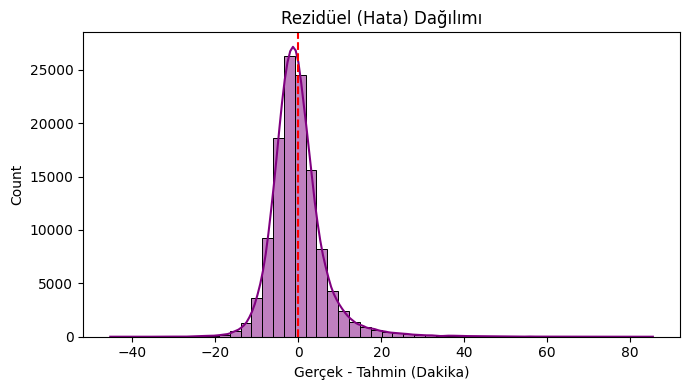

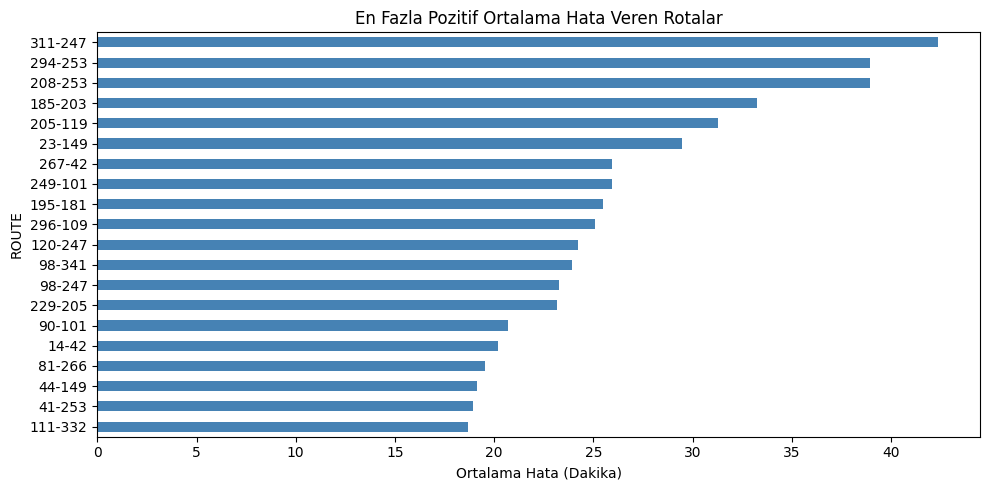

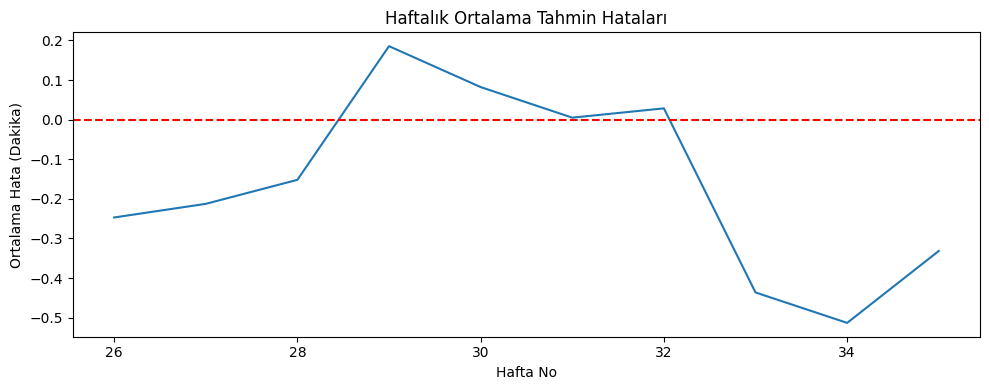

In [ ]:
train_mask = df['FL_DATE'] < '2023-07-01'

import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test - y_pred
df_result = df.loc[~train_mask].copy()
df_result['y_true'] = y_test
df_result['y_pred'] = y_pred
df_result['residual'] = residuals

# 1) Genel hata dağılımı
plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Rezidüel (Hata) Dağılımı')
plt.xlabel('Gerçek - Tahmin (Dakika)')
plt.tight_layout()
plt.show()

# 2) Rota bazlı ortalama hata
plt.figure(figsize=(10,5))
route_errors = df_result.groupby('ROUTE')['residual'].mean().sort_values()
route_errors.tail(20).plot(kind='barh', color='steelblue')
plt.title('En Fazla Pozitif Ortalama Hata Veren Rotalar')
plt.xlabel('Ortalama Hata (Dakika)')
plt.tight_layout()
plt.show()

# 3) Zaman bazlı hata (haftalık ortalama)
plt.figure(figsize=(10,4))
df_result['WEEK'] = df_result['FL_DATE'].dt.isocalendar().week
sns.lineplot(data=df_result.groupby('WEEK')['residual'].mean())
plt.title('Haftalık Ortalama Tahmin Hataları')
plt.xlabel('Hafta No')
plt.ylabel('Ortalama Hata (Dakika)')
plt.axhline(0, linestyle='--', color='red')
plt.tight_layout()
plt.show()


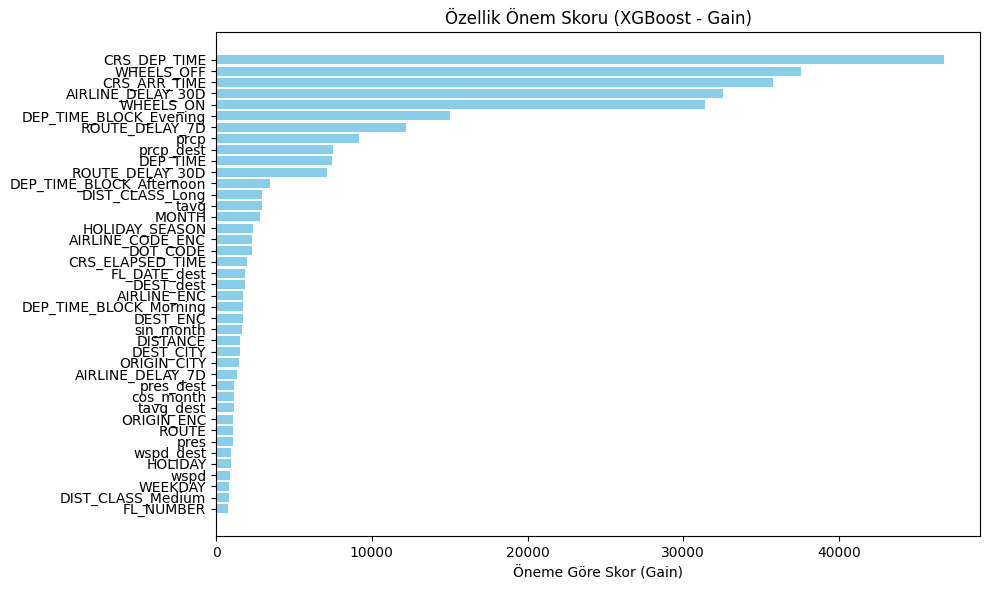

In [ ]:
import matplotlib.pyplot as plt

# Booster üzerinden önem değerlerini al
booster = best_model.get_booster()
importance = booster.get_score(importance_type='gain')

# Sıralı hale getir
sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

# Görselleştir
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_importance.keys())[::-1], list(sorted_importance.values())[::-1], color='skyblue')
plt.xlabel('Öneme Göre Skor (Gain)')
plt.title('Özellik Önem Skoru (XGBoost - Gain)')
plt.tight_layout()
plt.show()


In [ ]:
# Eğer SHAP yüklü değilse yükle
!pip install shap

import shap
import matplotlib.pyplot as plt

# TreeExplainer kullanarak modelin açıklanabilirliğini başlat
explainer = shap.Explainer(best_model)  # xgb_model bizim eğittiğimiz XGBoost model
shap_values = explainer(X_test)        # Test verisine göre SHAP değerlerini al


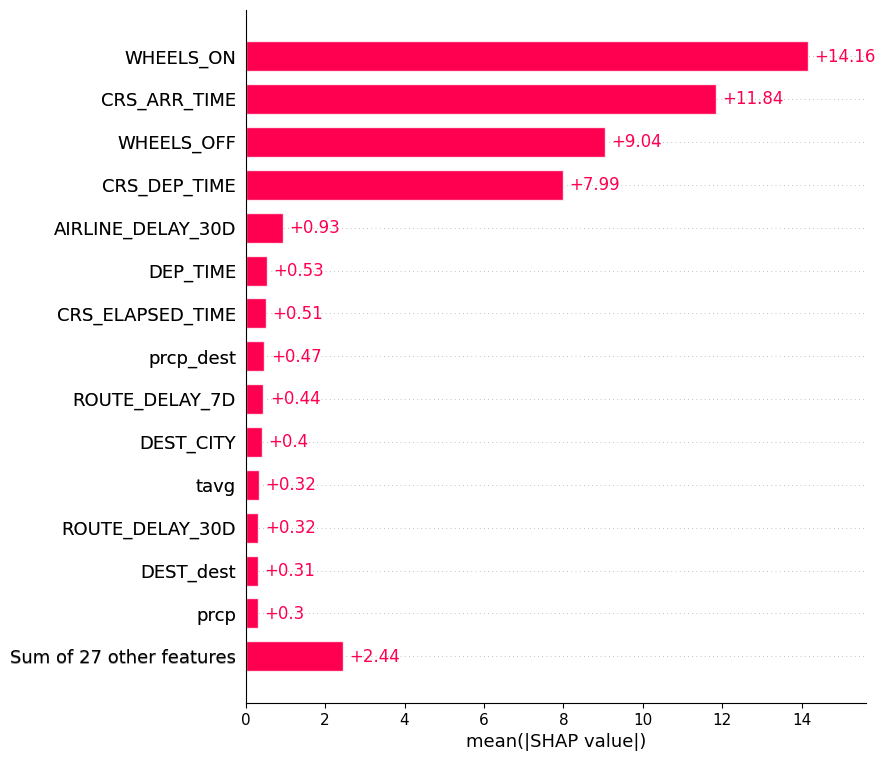

In [ ]:
# Özelliklerin ortalama etkilerini görsel olarak göster
shap.plots.bar(shap_values, max_display=15)
plt.show()


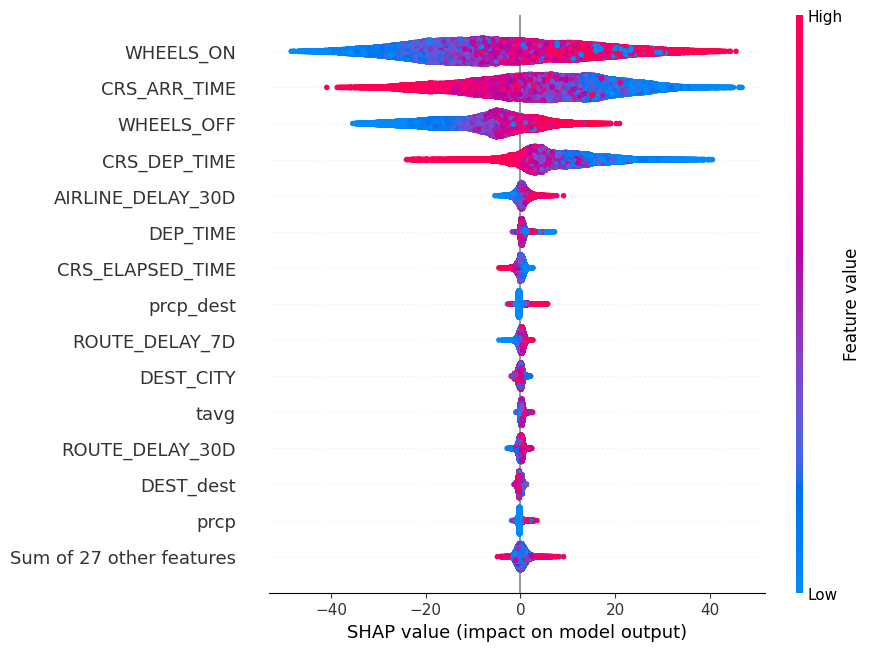

In [ ]:
shap.plots.beeswarm(shap_values, max_display=15)


In [ ]:
!pip install shap
import shap

# JavaScript kütüphanesini yükle
shap.initjs()

shap.plots.force(shap_values[0])


In [ ]:


# Özelliklerin SHAP değerlerini yazdır
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_summary = shap_df.describe()

# Özelliklerin SHAP değerlerinin özetini al
print(shap_summary)

# Özelliklerin toplam SHAP değerini sıralayarak önemli olanları göster
shap_importance = shap_df.mean().abs().sort_values(ascending=False)
print(shap_importance)


            DOT_CODE      FL_NUMBER    ORIGIN_CITY      DEST_CITY  \
count  119920.000000  119920.000000  119920.000000  119920.000000   
mean       -0.024767       0.003437       0.036005      -0.085446   
std         0.381616       0.103443       0.149122       0.524732   
min        -1.818955      -0.962380      -1.077303      -1.927048   
25%        -0.249175      -0.017793      -0.014113      -0.394862   
50%        -0.131581       0.019993       0.049658      -0.048248   
75%         0.067283       0.051991       0.107724       0.229026   
max         3.322513       1.780755       1.483557       2.180101   

        CRS_DEP_TIME       DEP_TIME     WHEELS_OFF      WHEELS_ON  \
count  119920.000000  119920.000000  119920.000000  119920.000000   
mean        7.094119       0.525947      -7.241051      -4.267264   
std         7.332296       0.510316       9.264310      16.545368   
min       -24.076496      -1.685172     -35.434853     -48.443424   
25%         2.191536       0.2364

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
!pip install -U scikit-learn

# Random Forest modelini oluşturma
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Modeli eğitme
rf_model.fit(X_train, y_train)

# Tahminler
y_pred_rf = rf_model.predict(X_test)

# Performans metriklerini hesaplama
# Performans metriklerini hesaplama
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))  # 'squared' parametresi kaldırıldı
r2_rf = r2_score(y_test, y_pred_rf)

# Sonuçları yazdırma
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R²: {r2_rf}")



Random Forest MAE: 4.3428170446964645
Random Forest RMSE: 6.821118694918509
Random Forest R²: 0.9171620115353412


In [ ]:
# XGBoost modelinin tahminlerini alalım
y_pred_xgb = best_model.predict(X_test)

# Performans metriklerini hesaplama (XGBoost için)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))  # 'squared' parametresi kaldırıldı
r2_xgb = r2_score(y_test, y_pred_xgb)

# Sonuçları yazdırma
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R²: {r2_xgb}")


XGBoost MAE: 4.560120619621289
XGBoost RMSE: 6.70739709603821
XGBoost R²: 0.9199011339439085


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# LightGBM modelini oluştur
lgb = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

# Modeli eğit
lgb.fit(X_train, y_train)

# Tahmin yap
y_pred_lgb = lgb.predict(X_test)

# Performans metriklerini hesapla
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

# Sonuçları yazdır
print(f"LightGBM MAE: {mae_lgb:.3f}")
print(f"LightGBM RMSE: {rmse_lgb:.3f}")
print(f"LightGBM R²: {r2_lgb:.3f}\n")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6517
[LightGBM] [Info] Number of data points in the train set: 334493, number of used features: 41
[LightGBM] [Info] Start training from score 1.219329
LightGBM MAE: 6.728
LightGBM RMSE: 9.321
LightGBM R²: 0.845



In [ ]:
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# CatBoost modelini oluştur
cat = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=0
)

# Modeli eğit
cat.fit(X_train, y_train)

# Tahmin yap
y_pred_cat = cat.predict(X_test)

# Performans metriklerini hesapla
mae_cat = mean_absolute_error(y_test, y_pred_cat)

# RMSE'yi manuel olarak hesapla
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))

# R²'yi hesapla
r2_cat = r2_score(y_test, y_pred_cat)

# Sonuçları yazdır
print(f"CatBoost MAE: {mae_cat:.3f}")
print(f"CatBoost RMSE: {rmse_cat:.3f}")
print(f"CatBoost R²: {r2_cat:.3f}\n")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00
CatBoost MAE: 10.495
CatBoost RMSE: 13.581
CatBoost R²: 0.672



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Ölçeklendirme
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Zaman serisi uyumlu 3D şekle dönüştürme (timesteps=1)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model mimarisi
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Eğitim
history = model.fit(
    X_train_lstm, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

Epoch 1/20
9408/9408 - 41s - 4ms/step - loss: 458.1855 - val_loss: 368.5320
Epoch 2/20
9408/9408 - 40s - 4ms/step - loss: 410.9290 - val_loss: 319.0638
Epoch 3/20
9408/9408 - 31s - 3ms/step - loss: 330.0803 - val_loss: 240.0932
Epoch 4/20
9408/9408 - 40s - 4ms/step - loss: 263.6952 - val_loss: 212.6788
Epoch 5/20
9408/9408 - 43s - 5ms/step - loss: 235.6895 - val_loss: 183.0668
Epoch 6/20
9408/9408 - 30s - 3ms/step - loss: 215.6089 - val_loss: 185.9927
Epoch 7/20
9408/9408 - 42s - 4ms/step - loss: 196.6745 - val_loss: 151.0259
Epoch 8/20
9408/9408 - 41s - 4ms/step - loss: 180.1973 - val_loss: 140.7053
Epoch 9/20
9408/9408 - 28s - 3ms/step - loss: 165.9140 - val_loss: 130.4890
Epoch 10/20
9408/9408 - 41s - 4ms/step - loss: 153.6099 - val_loss: 122.3480
Epoch 11/20
9408/9408 - 29s - 3ms/step - loss: 142.4264 - val_loss: 113.3599
Epoch 12/20
9408/9408 - 28s - 3ms/step - loss: 133.5850 - val_loss: 108.9329
Epoch 13/20
9408/9408 - 28s - 3ms/step - loss: 126.0636 - val_loss: 104.6074
Epoch 14

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Öngörü ve metrikler
y_pred_lstm = model.predict(X_test_lstm).flatten()

# MAE hesapla
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

# RMSE'yi manuel olarak hesapla
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

# R² hesapla
r2_lstm = r2_score(y_test, y_pred_lstm)

# Sonuçları yazdır
print(f"LSTM MAE: {mae_lstm:.3f}")
print(f"LSTM RMSE: {rmse_lstm:.3f}")
print(f"LSTM R²: {r2_lstm:.3f}\n")


3748/3748 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
LSTM MAE: 8.571
LSTM RMSE: 10.967
LSTM R²: 0.786



            Model        MAE       RMSE        R2
0         XGBoost   4.560121   6.707397  0.919901
1  Random Forrest   4.342817   6.821119  0.917162
2        LightGBM   6.727924   9.321300  0.845307
3        CatBoost  10.495197  13.580748  0.671628
4            LSTM   8.571016  10.966858  0.785867


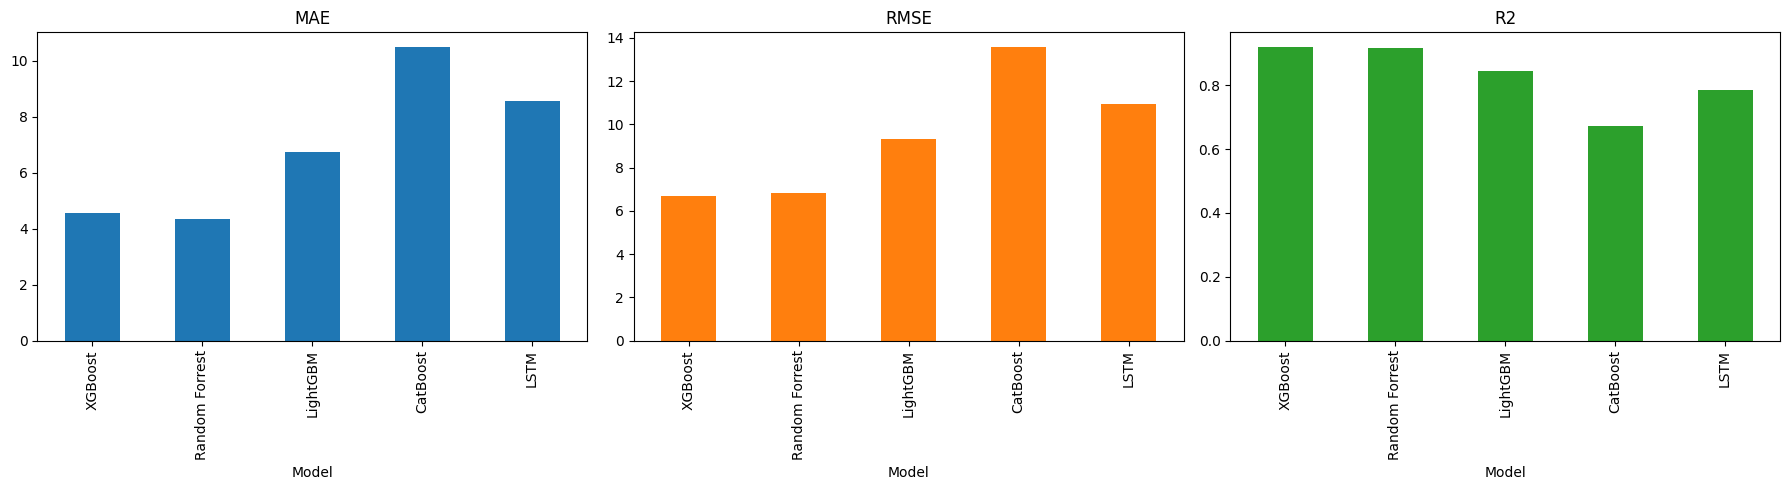

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forrest','LightGBM', 'CatBoost', 'LSTM'],
    'MAE': [mae_xgb,mae_rf, mae_lgb, mae_cat, mae_lstm],
    'RMSE': [rmse_xgb,rmse_rf, rmse_lgb, rmse_cat, rmse_lstm],
    'R2': [r2_xgb, r2_rf, r2_lgb, r2_cat, r2_lstm]
})

print(results)

# Görselleştirme
results.set_index('Model', inplace=True)
results.plot(kind='bar', subplots=True, layout=(1,3), figsize=(18,5), legend=False)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib

# -------------------------
# 1. Veriyi hazırla
# -------------------------
# X_train, y_train, X_test, y_test zaten hazırlanmış olmalı
# Örnek:
# X = df[FEATURE_COLS]
# y = df[TARGET_COL]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# 2. Ölçeklendirme
# -------------------------
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Kaydet: Flask'te kullanacağız
joblib.dump(scaler, "scaler_flask.save")

# -------------------------
# 3. LSTM girişine uygun reshape (timesteps=1)
# -------------------------
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# -------------------------
# 4. LSTM modeli tanımla
# -------------------------
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[1])))  # 1 timestep, feature sayısı kadar giriş
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# -------------------------
# 5. Modeli eğit
# -------------------------
history = model.fit(
    X_train_lstm, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

# -------------------------
# 6. Modeli kaydet (Flask için)
# -------------------------
model.save("lstm_flask_model.h5")
print("✅ Model ve scaler başarıyla kaydedildi.")


Epoch 1/20
9408/9408 - 31s - 3ms/step - loss: 457.3103 - val_loss: 369.9106
Epoch 2/20
9408/9408 - 42s - 4ms/step - loss: 411.5623 - val_loss: 318.4676
Epoch 3/20
9408/9408 - 29s - 3ms/step - loss: 330.4676 - val_loss: 248.7981
Epoch 4/20
9408/9408 - 30s - 3ms/step - loss: 265.0387 - val_loss: 202.2662
Epoch 5/20
9408/9408 - 39s - 4ms/step - loss: 237.6488 - val_loss: 183.9184
Epoch 6/20
9408/9408 - 29s - 3ms/step - loss: 215.9578 - val_loss: 164.1351
Epoch 7/20
9408/9408 - 42s - 4ms/step - loss: 196.8073 - val_loss: 154.1574
Epoch 8/20
9408/9408 - 40s - 4ms/step - loss: 179.7055 - val_loss: 153.6766
Epoch 9/20
9408/9408 - 41s - 4ms/step - loss: 165.0142 - val_loss: 140.7299
Epoch 10/20
9408/9408 - 31s - 3ms/step - loss: 152.6062 - val_loss: 122.4897
Epoch 11/20
9408/9408 - 39s - 4ms/step - loss: 142.1238 - val_loss: 115.5148
Epoch 12/20
9408/9408 - 29s - 3ms/step - loss: 133.1857 - val_loss: 108.7660
Epoch 13/20
9408/9408 - 41s - 4ms/step - loss: 125.9190 - val_loss: 105.1419
Epoch 14

✅ Model ve scaler başarıyla kaydedildi.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tahmin
y_pred = model.predict(X_test_lstm).flatten()

# Metrikler
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"LSTM MAE: {mae:.3f}")
print(f"LSTM RMSE: {rmse:.3f}")
print(f"LSTM R²: {r2:.3f}")


3748/3748 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
LSTM MAE: 8.141
LSTM RMSE: 10.603
LSTM R²: 0.800


In [ ]:
import pickle

# scaler nesnesi zaten varsa, bunu kaydet
with open('pre_lstm.pkl', 'wb') as f:
    pickle.dump(scaler, f)
